# Graph Transform Tool

https://petewarden.com/2016/12/30/rewriting-tensorflow-graphs-with-the-gtt/

https://github.com/tensorflow/tensorflow/tree/master/tensorflow/tools/graph_transforms

# Optimize Trained Models for Inference
## Types of Optimizations
* Remove training-only operations (checkpoint saving, drop out)
* Strip out unused nodes
* Remove debug operations
* Fold batch normalization ops into weights (super cool)
* Round weights
* Quantize weights

# Compare Types of Optimizations

## Original Model (CPU)

### File Size

In [1]:
%%bash

ls -l /root/models/optimize_me/linear/cpu/

total 52
-rw-r--r-- 1 root root   149 May 24 14:26 checkpoint
-rw-r--r-- 1 root root     8 May 24 14:26 model.ckpt.data-00000-of-00001
-rw-r--r-- 1 root root   143 May 24 14:26 model.ckpt.index
-rw-r--r-- 1 root root 21374 May 24 14:26 model.ckpt.meta
-rw-r--r-- 1 root root 14947 May 24 14:26 unoptimized_model_cpu.pb


### Graph

In [2]:
%%bash

summarize_graph --in_graph=/root/models/optimize_me/linear/cpu/unoptimized_model_cpu.pb

Found 2 possible inputs: (name=x_observed, type=float(1), shape=[]) (name=y_observed, type=float(1), shape=[]) 
Found 2 variables: (name=weights, type=float(1), shape=[]) (name=bias, type=float(1), shape=[]) 
Found 5 possible outputs: (name=gradients/sub_grad/tuple/control_dependency_1, op=Identity) (name=gradients/mul_grad/tuple/control_dependency_1, op=Identity) (name=Merge/MergeSummary, op=MergeSummary) (name=save/Identity, op=Identity) (name=save_1/control_dependency, op=Identity) 
Found 34 (34) const parameters, 0 (0) variable parameters, and 28 control_edges
101 nodes assigned to device '/device:CPU:0'Op types used: 36 Const, 11 Identity, 10 NoOp, 7 Mul, 7 Reshape, 6 Assign, 6 Sum, 6 Shape, 4 RestoreV2, 3 Add, 3 Sub, 3 BroadcastGradientArgs, 2 SaveV2, 2 VariableV2, 2 RandomUniform, 2 ApplyGradientDescent, 2 Prod, 2 Placeholder, 1 Pack, 1 Neg, 1 RealDiv, 1 MergeV2Checkpoints, 1 MergeSummary, 1 Mean, 1 ScalarSummary, 1 Maximum, 1 ShardedFilename, 1 Square, 1 StringJoin, 1 FloorDiv,

2017-05-24 14:27:16.627731: W tensorflow/tools/graph_transforms/summarize_graph_main.cc:183] Decoding Tensor failed for nodeweights
2017-05-24 14:27:16.627848: W tensorflow/tools/graph_transforms/summarize_graph_main.cc:183] Decoding Tensor failed for nodebias


In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import re
from google.protobuf import text_format
from tensorflow.core.framework import graph_pb2

def convert_graph_to_dot(input_graph, output_dot, is_input_graph_binary):
    graph = graph_pb2.GraphDef()
    with open(input_graph, "rb") as fh:
        if is_input_graph_binary:
            graph.ParseFromString(fh.read())
        else:
            text_format.Merge(fh.read(), graph)
    with open(output_dot, "wt") as fh:
        print("digraph graphname {", file=fh)
        for node in graph.node:
            output_name = node.name
            print("  \"" + output_name + "\" [label=\"" + node.op + "\"];", file=fh)
            for input_full_name in node.input:
                parts = input_full_name.split(":")
                input_name = re.sub(r"^\^", "", parts[0])
                print("  \"" + input_name + "\" -> \"" + output_name + "\";", file=fh)
        print("}", file=fh)
        print("Created dot file '%s' for graph '%s'." % (output_dot, input_graph))
        

In [4]:
input_graph='/root/models/optimize_me/linear/cpu/unoptimized_model_cpu.pb'
output_dot='/root/notebooks/unoptimized_cpu.dot'
convert_graph_to_dot(input_graph=input_graph, output_dot=output_dot, is_input_graph_binary=True)

Created dot file '/root/notebooks/unoptimized_cpu.dot' for graph '/root/models/optimize_me/linear/cpu/unoptimized_model_cpu.pb'.


In [5]:
%%bash

dot -T png /root/notebooks/unoptimized_cpu.dot \
    -o /root/notebooks/unoptimized_cpu.png > /tmp/a.out

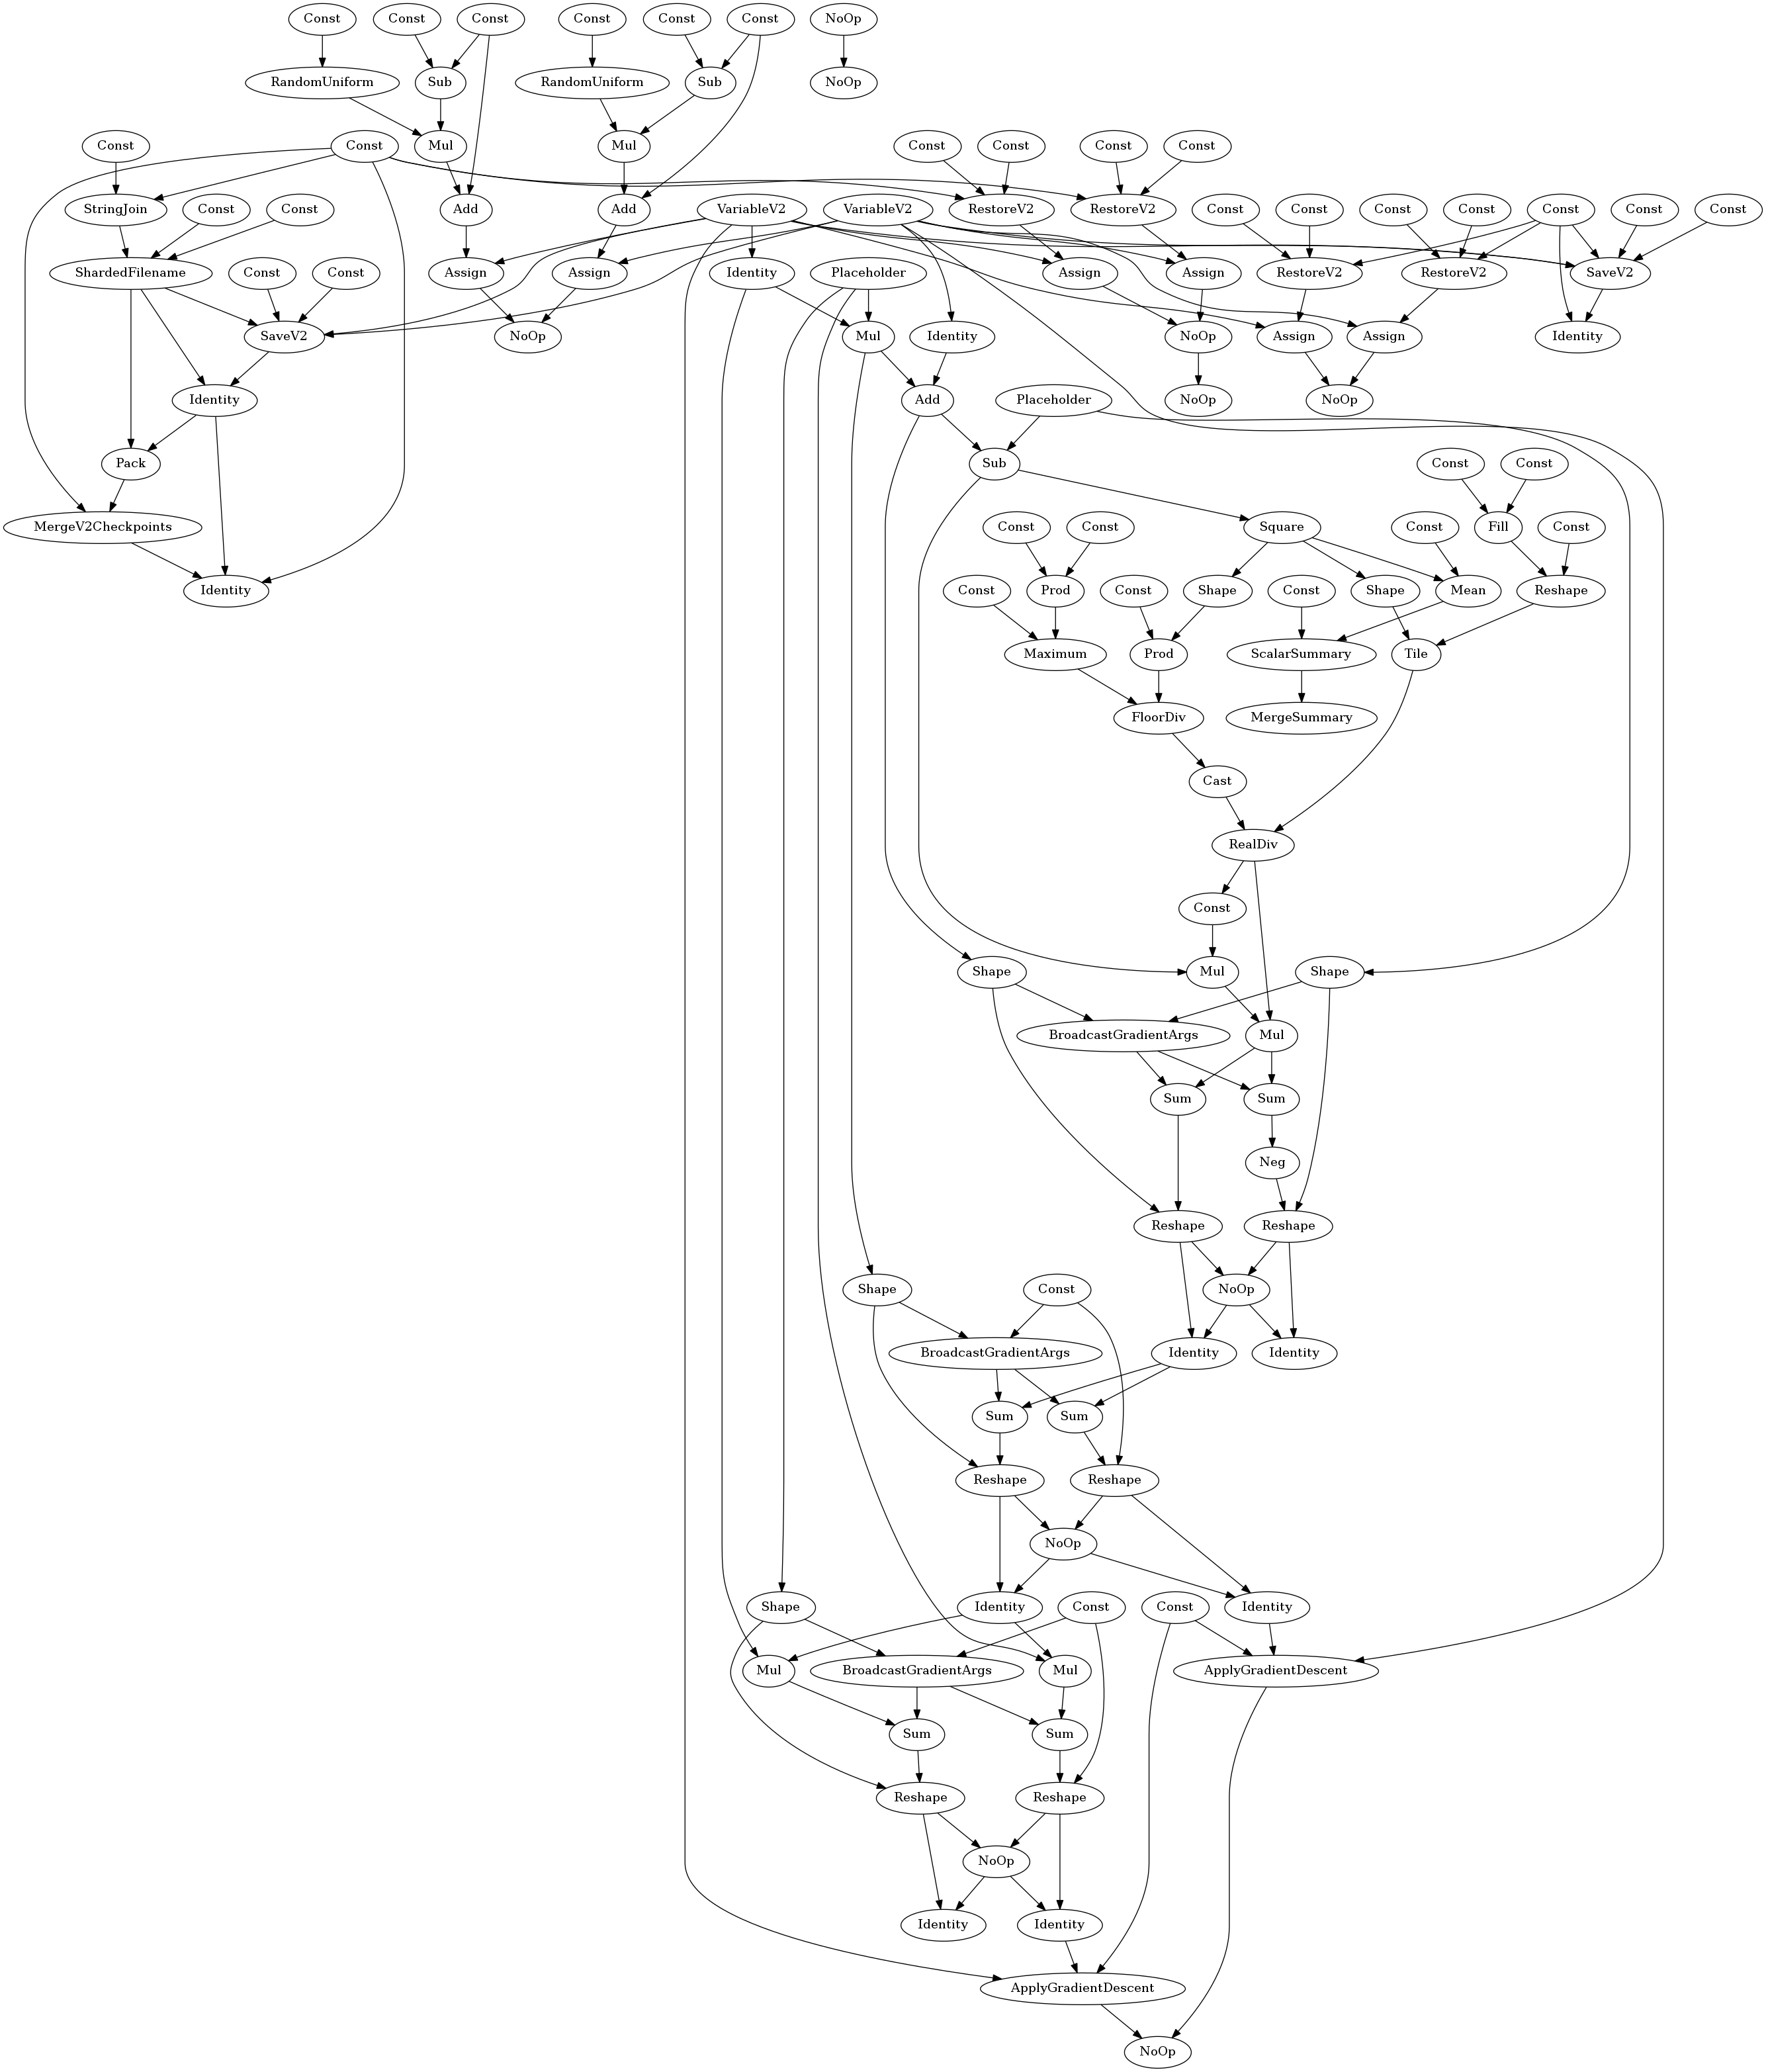

In [6]:
from IPython.display import Image

Image('/root/notebooks/unoptimized_cpu.png', width=1024, height=768)

### Benchmarks

In [7]:
%%bash

benchmark_model --graph=/root/models/optimize_me/linear/cpu/unoptimized_model_cpu.pb \
    --input_layer=weights,bias,x_observed \
    --input_layer_type=float,float,float \
    --input_layer_shape=:: \
    --output_layer=add

2017-05-24 14:27:23.647211: I tensorflow/tools/benchmark/benchmark_model.cc:381] Graph: [/root/models/optimize_me/linear/cpu/unoptimized_model_cpu.pb]
2017-05-24 14:27:23.647299: I tensorflow/tools/benchmark/benchmark_model.cc:382] Input layers: [weights,bias,x_observed]
2017-05-24 14:27:23.647331: I tensorflow/tools/benchmark/benchmark_model.cc:383] Input shapes: [::]
2017-05-24 14:27:23.647341: I tensorflow/tools/benchmark/benchmark_model.cc:384] Input types: [float,float,float]
2017-05-24 14:27:23.647350: I tensorflow/tools/benchmark/benchmark_model.cc:385] Output layers: [add]
2017-05-24 14:27:23.647366: I tensorflow/tools/benchmark/benchmark_model.cc:386] Num runs: [50]
2017-05-24 14:27:23.647376: I tensorflow/tools/benchmark/benchmark_model.cc:387] Inter-run delay (seconds): [-1.0]
2017-05-24 14:27:23.647386: I tensorflow/tools/benchmark/benchmark_model.cc:388] Num threads: [-1]
2017-05-24 14:27:23.647395: I tensorflow/tools/benchmark/benchmark_model.cc:389] Benchmark name: []
20

## Strip Unused Nodes

In [93]:
%%bash

transform_graph \
    --in_graph=/root/models/optimize_me/linear/cpu/unoptimized_model_cpu.pb \
    --out_graph=/root/models/optimize_me/linear/cpu/strip_unused_optimized_cpu.pb \
    --inputs='x_observed,weights,bias' \
    --outputs='add' \
    --transforms='
strip_unused_nodes'

2017-05-24 15:24:27.134760: I tensorflow/tools/graph_transforms/transform_graph.cc:257] Applying strip_unused_nodes


In [77]:
%%bash

ls -l /root/models/optimize_me/linear/cpu

total 92
-rw-r--r-- 1 root root   149 May 24 14:26 checkpoint
-rw-r--r-- 1 root root   599 May 24 14:27 fold_batch_norms_optimized_cpu.pb
-rw-r--r-- 1 root root   599 May 24 14:27 fold_constants_optimized_cpu.pb
-rw-r--r-- 1 root root   424 May 24 14:44 fully_optimized_cpu.pb
-rw-r--r-- 1 root root     8 May 24 14:26 model.ckpt.data-00000-of-00001
-rw-r--r-- 1 root root   143 May 24 14:26 model.ckpt.index
-rw-r--r-- 1 root root 21374 May 24 14:26 model.ckpt.meta
-rw-r--r-- 1 root root  2507 May 24 14:44 quantize_nodes_optimized_cpu.pb
-rw-r--r-- 1 root root   599 May 24 14:27 quantize_weights_optimized_cpu.pb
-rw-r--r-- 1 root root 14945 May 24 14:44 sort_by_execution_order_optimized_cpu.pb
-rw-r--r-- 1 root root   446 May 24 15:21 strip_unused_optimized_cpu.pb
-rw-r--r-- 1 root root 14947 May 24 14:26 unoptimized_model_cpu.pb


### Graph

In [78]:
%%bash

summarize_graph --in_graph=/root/models/optimize_me/linear/cpu/strip_unused_optimized_cpu.pb

Found 3 possible inputs: (name=weights, type=float(1), shape=[]) (name=bias, type=float(1), shape=[]) (name=x_observed, type=float(1), shape=[]) 
No variables spotted.
Found 1 possible outputs: (name=add, op=Add) 
Found 0 (0) const parameters, 0 (0) variable parameters, and 0 control_edges
5 nodes assigned to device '/device:CPU:0'Op types used: 3 Placeholder, 2 Identity, 1 Add, 1 Mul
To use with tensorflow/tools/benchmark:benchmark_model try these arguments:
bazel run tensorflow/tools/benchmark:benchmark_model -- --graph=/root/models/optimize_me/linear/cpu/strip_unused_optimized_cpu.pb --show_flops --logtostderr --input_layer=weights,bias,x_observed --input_layer_type=float,float,float --input_layer_shape=:: --output_layer=add


In [79]:
input_graph='/root/models/optimize_me/linear/cpu/strip_unused_optimized_cpu.pb'
output_dot='/root/notebooks/strip_unused_optimized_cpu.dot'
convert_graph_to_dot(input_graph=input_graph, output_dot=output_dot, is_input_graph_binary=True)

Created dot file '/root/notebooks/strip_unused_optimized_cpu.dot' for graph '/root/models/optimize_me/linear/cpu/strip_unused_optimized_cpu.pb'.


In [80]:
%%bash

dot -T png /root/notebooks/strip_unused_optimized_cpu.dot \
    -o /root/notebooks/strip_unused_optimized_cpu.png > /tmp/a.out

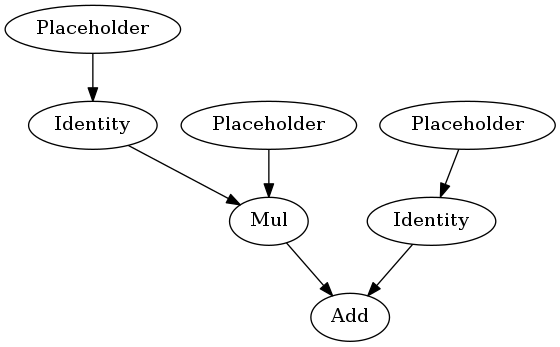

In [81]:
from IPython.display import Image

Image('/root/notebooks/strip_unused_optimized_cpu.png')

### Benchmark

In [82]:
%%bash

benchmark_model --graph=/root/models/optimize_me/linear/cpu/strip_unused_optimized_cpu.pb \
    --input_layer=weights,bias,x_observed \
    --input_layer_type=float,float,float \
    --input_layer_shape=:: \
    --output_layer=add

2017-05-24 15:21:30.581254: I tensorflow/tools/benchmark/benchmark_model.cc:381] Graph: [/root/models/optimize_me/linear/cpu/strip_unused_optimized_cpu.pb]
2017-05-24 15:21:30.581335: I tensorflow/tools/benchmark/benchmark_model.cc:382] Input layers: [weights,bias,x_observed]
2017-05-24 15:21:30.581357: I tensorflow/tools/benchmark/benchmark_model.cc:383] Input shapes: [::]
2017-05-24 15:21:30.581367: I tensorflow/tools/benchmark/benchmark_model.cc:384] Input types: [float,float,float]
2017-05-24 15:21:30.581376: I tensorflow/tools/benchmark/benchmark_model.cc:385] Output layers: [add]
2017-05-24 15:21:30.581391: I tensorflow/tools/benchmark/benchmark_model.cc:386] Num runs: [50]
2017-05-24 15:21:30.581401: I tensorflow/tools/benchmark/benchmark_model.cc:387] Inter-run delay (seconds): [-1.0]
2017-05-24 15:21:30.581411: I tensorflow/tools/benchmark/benchmark_model.cc:388] Num threads: [-1]
2017-05-24 15:21:30.581420: I tensorflow/tools/benchmark/benchmark_model.cc:389] Benchmark name: 

## Remove Nodes
Remove pesky `Identity` and `CheckNumerics`

In [95]:
%%bash

transform_graph \
    --in_graph=/root/models/optimize_me/linear/cpu/strip_unused_optimized_cpu.pb \
    --out_graph=/root/models/optimize_me/linear/cpu/remove_nodes_optimized_cpu.pb \
    --inputs='x_observed,weights,bias' \
    --outputs='add' \
    --transforms='
strip_unused_nodes
remove_nodes(op=Identity, op=CheckNumerics)'

2017-05-24 15:25:05.124508: I tensorflow/tools/graph_transforms/transform_graph.cc:257] Applying strip_unused_nodes
2017-05-24 15:25:05.124676: I tensorflow/tools/graph_transforms/transform_graph.cc:257] Applying remove_nodes


In [96]:
%%bash

ls -l /root/models/optimize_me/linear/cpu

total 96
-rw-r--r-- 1 root root   149 May 24 14:26 checkpoint
-rw-r--r-- 1 root root   599 May 24 14:27 fold_batch_norms_optimized_cpu.pb
-rw-r--r-- 1 root root   599 May 24 14:27 fold_constants_optimized_cpu.pb
-rw-r--r-- 1 root root   424 May 24 14:44 fully_optimized_cpu.pb
-rw-r--r-- 1 root root     8 May 24 14:26 model.ckpt.data-00000-of-00001
-rw-r--r-- 1 root root   143 May 24 14:26 model.ckpt.index
-rw-r--r-- 1 root root 21374 May 24 14:26 model.ckpt.meta
-rw-r--r-- 1 root root  2507 May 24 14:44 quantize_nodes_optimized_cpu.pb
-rw-r--r-- 1 root root   599 May 24 14:27 quantize_weights_optimized_cpu.pb
-rw-r--r-- 1 root root   271 May 24 15:25 remove_nodes_optimized_cpu.pb
-rw-r--r-- 1 root root 14945 May 24 14:44 sort_by_execution_order_optimized_cpu.pb
-rw-r--r-- 1 root root   271 May 24 15:24 strip_unused_optimized_cpu.pb
-rw-r--r-- 1 root root 14947 May 24 14:26 unoptimized_model_cpu.pb


### Graph

In [97]:
%%bash

summarize_graph --in_graph=/root/models/optimize_me/linear/cpu/remove_nodes_optimized_cpu.pb

Found 3 possible inputs: (name=weights, type=float(1), shape=[]) (name=bias, type=float(1), shape=[]) (name=x_observed, type=float(1), shape=[]) 
No variables spotted.
Found 1 possible outputs: (name=add, op=Add) 
Found 0 (0) const parameters, 0 (0) variable parameters, and 0 control_edges
3 nodes assigned to device '/device:CPU:0'Op types used: 3 Placeholder, 1 Add, 1 Mul
To use with tensorflow/tools/benchmark:benchmark_model try these arguments:
bazel run tensorflow/tools/benchmark:benchmark_model -- --graph=/root/models/optimize_me/linear/cpu/remove_nodes_optimized_cpu.pb --show_flops --logtostderr --input_layer=weights,bias,x_observed --input_layer_type=float,float,float --input_layer_shape=:: --output_layer=add


In [98]:
input_graph='/root/models/optimize_me/linear/cpu/remove_nodes_optimized_cpu.pb'
output_dot='/root/notebooks/remove_nodes_optimized_cpu.dot'
convert_graph_to_dot(input_graph=input_graph, output_dot=output_dot, is_input_graph_binary=True)

Created dot file '/root/notebooks/remove_nodes_optimized_cpu.dot' for graph '/root/models/optimize_me/linear/cpu/remove_nodes_optimized_cpu.pb'.


In [99]:
%%bash

dot -T png /root/notebooks/remove_nodes_optimized_cpu.dot \
    -o /root/notebooks/remove_nodes_optimized_cpu.png > /tmp/a.out

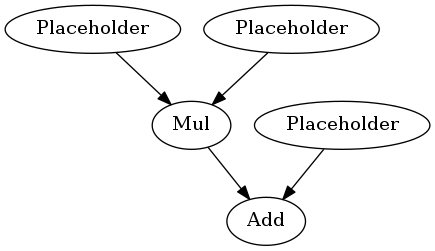

In [100]:
from IPython.display import Image

Image('/root/notebooks/remove_nodes_optimized_cpu.png')

### Benchmark

In [101]:
%%bash

benchmark_model --graph=/root/models/optimize_me/linear/cpu/strip_unused_optimized_cpu.pb \
    --input_layer=weights,bias,x_observed \
    --input_layer_type=float,float,float \
    --input_layer_shape=:: \
    --output_layer=add

2017-05-24 15:27:24.350356: I tensorflow/tools/benchmark/benchmark_model.cc:381] Graph: [/root/models/optimize_me/linear/cpu/strip_unused_optimized_cpu.pb]
2017-05-24 15:27:24.350453: I tensorflow/tools/benchmark/benchmark_model.cc:382] Input layers: [weights,bias,x_observed]
2017-05-24 15:27:24.350470: I tensorflow/tools/benchmark/benchmark_model.cc:383] Input shapes: [::]
2017-05-24 15:27:24.350480: I tensorflow/tools/benchmark/benchmark_model.cc:384] Input types: [float,float,float]
2017-05-24 15:27:24.350490: I tensorflow/tools/benchmark/benchmark_model.cc:385] Output layers: [add]
2017-05-24 15:27:24.350506: I tensorflow/tools/benchmark/benchmark_model.cc:386] Num runs: [50]
2017-05-24 15:27:24.350516: I tensorflow/tools/benchmark/benchmark_model.cc:387] Inter-run delay (seconds): [-1.0]
2017-05-24 15:27:24.350526: I tensorflow/tools/benchmark/benchmark_model.cc:388] Num threads: [-1]
2017-05-24 15:27:24.350536: I tensorflow/tools/benchmark/benchmark_model.cc:389] Benchmark name: 

## Fold Constants

In [108]:
%%bash

transform_graph \
--in_graph=/root/models/optimize_me/linear/cpu/unoptimized_model_cpu.pb \
--out_graph=/root/models/optimize_me/linear/cpu/fold_constants_optimized_cpu.pb \
--inputs='x_observed' \
--outputs='add' \
--transforms='
strip_unused_nodes
remove_nodes(op=Identity, op=CheckNumerics)
fold_constants(ignore_errors=true)'

2017-05-24 15:28:28.595328: I tensorflow/tools/graph_transforms/transform_graph.cc:257] Applying strip_unused_nodes
2017-05-24 15:28:28.595625: I tensorflow/tools/graph_transforms/transform_graph.cc:257] Applying remove_nodes
2017-05-24 15:28:28.596163: I tensorflow/tools/graph_transforms/transform_graph.cc:257] Applying fold_constants


### File Size

In [109]:
%%bash

ls -l /root/models/optimize_me/linear/cpu

total 96
-rw-r--r-- 1 root root   149 May 24 14:26 checkpoint
-rw-r--r-- 1 root root   599 May 24 14:27 fold_batch_norms_optimized_cpu.pb
-rw-r--r-- 1 root root   424 May 24 15:28 fold_constants_optimized_cpu.pb
-rw-r--r-- 1 root root   424 May 24 14:44 fully_optimized_cpu.pb
-rw-r--r-- 1 root root     8 May 24 14:26 model.ckpt.data-00000-of-00001
-rw-r--r-- 1 root root   143 May 24 14:26 model.ckpt.index
-rw-r--r-- 1 root root 21374 May 24 14:26 model.ckpt.meta
-rw-r--r-- 1 root root  2507 May 24 14:44 quantize_nodes_optimized_cpu.pb
-rw-r--r-- 1 root root   599 May 24 14:27 quantize_weights_optimized_cpu.pb
-rw-r--r-- 1 root root   271 May 24 15:25 remove_nodes_optimized_cpu.pb
-rw-r--r-- 1 root root 14945 May 24 14:44 sort_by_execution_order_optimized_cpu.pb
-rw-r--r-- 1 root root   271 May 24 15:24 strip_unused_optimized_cpu.pb
-rw-r--r-- 1 root root 14947 May 24 14:26 unoptimized_model_cpu.pb


### Graph

In [110]:
%%bash

summarize_graph --in_graph=/root/models/optimize_me/linear/cpu/fold_constants_optimized_cpu.pb

Found 1 possible inputs: (name=x_observed, type=float(1), shape=[]) 
Found 2 variables: (name=bias, type=float(1), shape=[]) (name=weights, type=float(1), shape=[]) 
Found 1 possible outputs: (name=add, op=Add) 
Found 0 (0) const parameters, 0 (0) variable parameters, and 0 control_edges
5 nodes assigned to device '/device:CPU:0'Op types used: 2 VariableV2, 1 Add, 1 Mul, 1 Placeholder
To use with tensorflow/tools/benchmark:benchmark_model try these arguments:
bazel run tensorflow/tools/benchmark:benchmark_model -- --graph=/root/models/optimize_me/linear/cpu/fold_constants_optimized_cpu.pb --show_flops --logtostderr --input_layer=x_observed,bias,weights --input_layer_type=float,float,float --input_layer_shape=:: --output_layer=add


2017-05-24 15:28:31.407687: W tensorflow/tools/graph_transforms/summarize_graph_main.cc:183] Decoding Tensor failed for nodebias
2017-05-24 15:28:31.407755: W tensorflow/tools/graph_transforms/summarize_graph_main.cc:183] Decoding Tensor failed for nodeweights


In [111]:
input_graph='/root/models/optimize_me/linear/cpu/fold_constants_optimized_cpu.pb'
output_dot='/root/notebooks/fold_constants_optimized_cpu.dot'
convert_graph_to_dot(input_graph=input_graph, output_dot=output_dot, is_input_graph_binary=True)

Created dot file '/root/notebooks/fold_constants_optimized_cpu.dot' for graph '/root/models/optimize_me/linear/cpu/fold_constants_optimized_cpu.pb'.


In [112]:
%%bash

dot -T png /root/notebooks/fold_constants_optimized_cpu.dot \
    -o /root/notebooks/fold_constants_optimized_cpu.png > /tmp/a.out

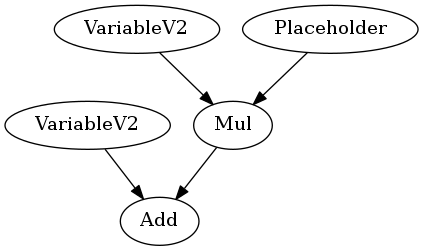

In [113]:
from IPython.display import Image

Image('/root/notebooks/fold_constants_optimized_cpu.png')

### Benchmarks

In [21]:
%%bash

benchmark_model --graph=/root/models/optimize_me/linear/cpu/fold_constants_optimized_cpu.pb \
                --input_layer=x_observed,bias,weights \
                --input_layer_type=float,float,float \
                --input_layer_shape=:: \
                --output_layer=add

2017-05-24 14:27:35.784312: I tensorflow/tools/benchmark/benchmark_model.cc:381] Graph: [/root/models/optimize_me/linear/cpu/fold_constants_optimized_cpu.pb]
2017-05-24 14:27:35.784385: I tensorflow/tools/benchmark/benchmark_model.cc:382] Input layers: [x_observed,bias,weights]
2017-05-24 14:27:35.784400: I tensorflow/tools/benchmark/benchmark_model.cc:383] Input shapes: [::]
2017-05-24 14:27:35.784409: I tensorflow/tools/benchmark/benchmark_model.cc:384] Input types: [float,float,float]
2017-05-24 14:27:35.784418: I tensorflow/tools/benchmark/benchmark_model.cc:385] Output layers: [add]
2017-05-24 14:27:35.784432: I tensorflow/tools/benchmark/benchmark_model.cc:386] Num runs: [50]
2017-05-24 14:27:35.784474: I tensorflow/tools/benchmark/benchmark_model.cc:387] Inter-run delay (seconds): [-1.0]
2017-05-24 14:27:35.784499: I tensorflow/tools/benchmark/benchmark_model.cc:388] Num threads: [-1]
2017-05-24 14:27:35.784510: I tensorflow/tools/benchmark/benchmark_model.cc:389] Benchmark name

## Fold Batch Normalizations
Prereq: `fold_constants`

In [116]:
%%bash

transform_graph \
--in_graph=/root/models/optimize_me/linear/cpu/unoptimized_model_cpu.pb \
--out_graph=/root/models/optimize_me/linear/cpu/fold_batch_norms_optimized_cpu.pb \
--inputs='x_observed' \
--outputs='add' \
--transforms='
strip_unused_nodes
remove_nodes(op=Identity, op=CheckNumerics)
fold_constants(ignore_errors=true)
fold_batch_norms
fold_old_batch_norms'

2017-05-24 15:33:38.795696: I tensorflow/tools/graph_transforms/transform_graph.cc:257] Applying strip_unused_nodes
2017-05-24 15:33:38.796008: I tensorflow/tools/graph_transforms/transform_graph.cc:257] Applying remove_nodes
2017-05-24 15:33:38.796605: I tensorflow/tools/graph_transforms/transform_graph.cc:257] Applying fold_constants
2017-05-24 15:33:38.810757: I tensorflow/tools/graph_transforms/transform_graph.cc:257] Applying fold_batch_norms
2017-05-24 15:33:38.810915: I tensorflow/tools/graph_transforms/transform_graph.cc:257] Applying fold_old_batch_norms


### File Size

In [117]:
%%bash

ls -l /root/models/optimize_me/linear/cpu

total 96
-rw-r--r-- 1 root root   149 May 24 14:26 checkpoint
-rw-r--r-- 1 root root   424 May 24 15:33 fold_batch_norms_optimized_cpu.pb
-rw-r--r-- 1 root root   424 May 24 15:28 fold_constants_optimized_cpu.pb
-rw-r--r-- 1 root root   424 May 24 14:44 fully_optimized_cpu.pb
-rw-r--r-- 1 root root     8 May 24 14:26 model.ckpt.data-00000-of-00001
-rw-r--r-- 1 root root   143 May 24 14:26 model.ckpt.index
-rw-r--r-- 1 root root 21374 May 24 14:26 model.ckpt.meta
-rw-r--r-- 1 root root  2507 May 24 14:44 quantize_nodes_optimized_cpu.pb
-rw-r--r-- 1 root root   599 May 24 14:27 quantize_weights_optimized_cpu.pb
-rw-r--r-- 1 root root   271 May 24 15:25 remove_nodes_optimized_cpu.pb
-rw-r--r-- 1 root root 14945 May 24 14:44 sort_by_execution_order_optimized_cpu.pb
-rw-r--r-- 1 root root   271 May 24 15:24 strip_unused_optimized_cpu.pb
-rw-r--r-- 1 root root 14947 May 24 14:26 unoptimized_model_cpu.pb


### Graph

In [118]:
%%bash

summarize_graph --in_graph=/root/models/optimize_me/linear/cpu/fold_batch_norms_optimized_cpu.pb

Found 1 possible inputs: (name=x_observed, type=float(1), shape=[]) 
Found 2 variables: (name=bias, type=float(1), shape=[]) (name=weights, type=float(1), shape=[]) 
Found 1 possible outputs: (name=add, op=Add) 
Found 0 (0) const parameters, 0 (0) variable parameters, and 0 control_edges
5 nodes assigned to device '/device:CPU:0'Op types used: 2 VariableV2, 1 Add, 1 Mul, 1 Placeholder
To use with tensorflow/tools/benchmark:benchmark_model try these arguments:
bazel run tensorflow/tools/benchmark:benchmark_model -- --graph=/root/models/optimize_me/linear/cpu/fold_batch_norms_optimized_cpu.pb --show_flops --logtostderr --input_layer=x_observed,bias,weights --input_layer_type=float,float,float --input_layer_shape=:: --output_layer=add


2017-05-24 15:33:41.311253: W tensorflow/tools/graph_transforms/summarize_graph_main.cc:183] Decoding Tensor failed for nodebias
2017-05-24 15:33:41.311313: W tensorflow/tools/graph_transforms/summarize_graph_main.cc:183] Decoding Tensor failed for nodeweights


In [119]:
input_graph='/root/models/optimize_me/linear/cpu/fold_batch_norms_optimized_cpu.pb'
output_dot='/root/notebooks/fold_batch_norms_optimized_cpu.dot'
convert_graph_to_dot(input_graph=input_graph, output_dot=output_dot, is_input_graph_binary=True)

Created dot file '/root/notebooks/fold_batch_norms_optimized_cpu.dot' for graph '/root/models/optimize_me/linear/cpu/fold_batch_norms_optimized_cpu.pb'.


In [120]:
%%bash

dot -T png /root/notebooks/fold_batch_norms_optimized_cpu.dot \
    -o /root/notebooks/fold_batch_norms_optimized_cpu.png > /tmp/a.out

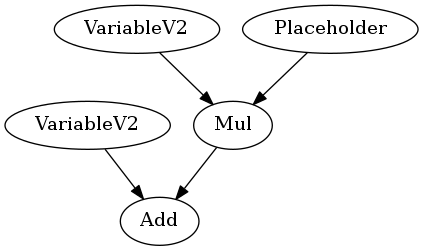

In [121]:
from IPython.display import Image

Image('/root/notebooks/fold_batch_norms_optimized_cpu.png')

### Benchmarks

In [28]:
%%bash

benchmark_model --graph=/root/models/optimize_me/linear/cpu/fold_batch_norms_optimized_cpu.pb \
                --input_layer=x_observed,bias,weights \
                --input_layer_type=float,float,float \
                --input_layer_shape=:: \
                --output_layer=add

2017-05-24 14:27:42.376892: I tensorflow/tools/benchmark/benchmark_model.cc:381] Graph: [/root/models/optimize_me/linear/cpu/fold_batch_norms_optimized_cpu.pb]
2017-05-24 14:27:42.376953: I tensorflow/tools/benchmark/benchmark_model.cc:382] Input layers: [x_observed,bias,weights]
2017-05-24 14:27:42.376983: I tensorflow/tools/benchmark/benchmark_model.cc:383] Input shapes: [::]
2017-05-24 14:27:42.376992: I tensorflow/tools/benchmark/benchmark_model.cc:384] Input types: [float,float,float]
2017-05-24 14:27:42.377001: I tensorflow/tools/benchmark/benchmark_model.cc:385] Output layers: [add]
2017-05-24 14:27:42.377013: I tensorflow/tools/benchmark/benchmark_model.cc:386] Num runs: [50]
2017-05-24 14:27:42.377023: I tensorflow/tools/benchmark/benchmark_model.cc:387] Inter-run delay (seconds): [-1.0]
2017-05-24 14:27:42.377031: I tensorflow/tools/benchmark/benchmark_model.cc:388] Num threads: [-1]
2017-05-24 14:27:42.377039: I tensorflow/tools/benchmark/benchmark_model.cc:389] Benchmark na

## Quantize Weights
Prereq: `fold_batch_norms`

In [122]:
%%bash

transform_graph \
--in_graph=/root/models/optimize_me/linear/cpu/unoptimized_model_cpu.pb \
--out_graph=/root/models/optimize_me/linear/cpu/quantize_weights_optimized_cpu.pb \
--inputs='x_observed' \
--outputs='add' \
--transforms='
strip_unused_nodes
remove_nodes(op=Identity, op=CheckNumerics)
fold_constants(ignore_errors=true)
fold_batch_norms
fold_old_batch_norms
quantize_weights'

2017-05-24 15:35:24.935806: I tensorflow/tools/graph_transforms/transform_graph.cc:257] Applying strip_unused_nodes
2017-05-24 15:35:24.936298: I tensorflow/tools/graph_transforms/transform_graph.cc:257] Applying remove_nodes
2017-05-24 15:35:24.936731: I tensorflow/tools/graph_transforms/transform_graph.cc:257] Applying fold_constants
2017-05-24 15:35:24.949905: I tensorflow/tools/graph_transforms/transform_graph.cc:257] Applying fold_batch_norms
2017-05-24 15:35:24.950068: I tensorflow/tools/graph_transforms/transform_graph.cc:257] Applying fold_old_batch_norms
2017-05-24 15:35:24.950213: I tensorflow/tools/graph_transforms/transform_graph.cc:257] Applying quantize_weights


### File Size

In [123]:
%%bash

ls -l /root/models/optimize_me/linear/cpu/

total 96
-rw-r--r-- 1 root root   149 May 24 14:26 checkpoint
-rw-r--r-- 1 root root   424 May 24 15:33 fold_batch_norms_optimized_cpu.pb
-rw-r--r-- 1 root root   424 May 24 15:28 fold_constants_optimized_cpu.pb
-rw-r--r-- 1 root root   424 May 24 14:44 fully_optimized_cpu.pb
-rw-r--r-- 1 root root     8 May 24 14:26 model.ckpt.data-00000-of-00001
-rw-r--r-- 1 root root   143 May 24 14:26 model.ckpt.index
-rw-r--r-- 1 root root 21374 May 24 14:26 model.ckpt.meta
-rw-r--r-- 1 root root  2507 May 24 14:44 quantize_nodes_optimized_cpu.pb
-rw-r--r-- 1 root root   424 May 24 15:35 quantize_weights_optimized_cpu.pb
-rw-r--r-- 1 root root   271 May 24 15:25 remove_nodes_optimized_cpu.pb
-rw-r--r-- 1 root root 14945 May 24 14:44 sort_by_execution_order_optimized_cpu.pb
-rw-r--r-- 1 root root   271 May 24 15:24 strip_unused_optimized_cpu.pb
-rw-r--r-- 1 root root 14947 May 24 14:26 unoptimized_model_cpu.pb


### Graph

In [124]:
%%bash

summarize_graph --in_graph=/root/models/optimize_me/linear/cpu/quantize_weights_optimized_cpu.pb

Found 1 possible inputs: (name=x_observed, type=float(1), shape=[]) 
Found 2 variables: (name=bias, type=float(1), shape=[]) (name=weights, type=float(1), shape=[]) 
Found 1 possible outputs: (name=add, op=Add) 
Found 0 (0) const parameters, 0 (0) variable parameters, and 0 control_edges
5 nodes assigned to device '/device:CPU:0'Op types used: 2 VariableV2, 1 Add, 1 Mul, 1 Placeholder
To use with tensorflow/tools/benchmark:benchmark_model try these arguments:
bazel run tensorflow/tools/benchmark:benchmark_model -- --graph=/root/models/optimize_me/linear/cpu/quantize_weights_optimized_cpu.pb --show_flops --logtostderr --input_layer=x_observed,bias,weights --input_layer_type=float,float,float --input_layer_shape=:: --output_layer=add


2017-05-24 15:35:26.972729: W tensorflow/tools/graph_transforms/summarize_graph_main.cc:183] Decoding Tensor failed for nodebias
2017-05-24 15:35:26.972826: W tensorflow/tools/graph_transforms/summarize_graph_main.cc:183] Decoding Tensor failed for nodeweights


In [125]:
input_graph='/root/models/optimize_me/linear/cpu/quantize_weights_optimized_cpu.pb'
output_dot='/root/notebooks/quantize_weights_optimized_cpu.dot'
convert_graph_to_dot(input_graph=input_graph, output_dot=output_dot, is_input_graph_binary=True)

Created dot file '/root/notebooks/quantize_weights_optimized_cpu.dot' for graph '/root/models/optimize_me/linear/cpu/quantize_weights_optimized_cpu.pb'.


In [126]:
%%bash

dot -T png /root/notebooks/quantize_weights_optimized_cpu.dot \
    -o /root/notebooks/quantize_weights_optimized_cpu.png > /tmp/a.out

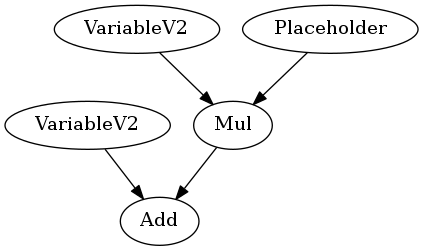

In [127]:
from IPython.display import Image

Image('/root/notebooks/quantize_weights_optimized_cpu.png')

### Benchmarks

In [128]:
%%bash

benchmark_model --graph=/root/models/optimize_me/linear/cpu/quantize_weights_optimized_cpu.pb --input_layer=x_observed,bias,weights --input_layer_type=float,float,float --input_layer_shape=:: --output_layer=add

2017-05-24 15:37:02.452881: I tensorflow/tools/benchmark/benchmark_model.cc:381] Graph: [/root/models/optimize_me/linear/cpu/quantize_weights_optimized_cpu.pb]
2017-05-24 15:37:02.452993: I tensorflow/tools/benchmark/benchmark_model.cc:382] Input layers: [x_observed,bias,weights]
2017-05-24 15:37:02.453012: I tensorflow/tools/benchmark/benchmark_model.cc:383] Input shapes: [::]
2017-05-24 15:37:02.453023: I tensorflow/tools/benchmark/benchmark_model.cc:384] Input types: [float,float,float]
2017-05-24 15:37:02.453034: I tensorflow/tools/benchmark/benchmark_model.cc:385] Output layers: [add]
2017-05-24 15:37:02.453049: I tensorflow/tools/benchmark/benchmark_model.cc:386] Num runs: [50]
2017-05-24 15:37:02.453060: I tensorflow/tools/benchmark/benchmark_model.cc:387] Inter-run delay (seconds): [-1.0]
2017-05-24 15:37:02.453070: I tensorflow/tools/benchmark/benchmark_model.cc:388] Num threads: [-1]
2017-05-24 15:37:02.453080: I tensorflow/tools/benchmark/benchmark_model.cc:389] Benchmark na

## Quantize Activations
Prereq: quantize weights

In [130]:
%%bash

transform_graph \
--in_graph=/root/models/optimize_me/linear/cpu/fold_batch_norms_optimized_cpu.pb \
--out_graph=/root/models/optimize_me/linear/cpu/quantize_nodes_optimized_cpu.pb \
--inputs='x_observed' \
--outputs='add' \
--transforms='
strip_unused_nodes
remove_nodes(op=Identity, op=CheckNumerics)
fold_constants(ignore_errors=true)
fold_batch_norms
fold_old_batch_norms
quantize_weights
quantize_nodes'

2017-05-24 15:37:20.712375: I tensorflow/tools/graph_transforms/transform_graph.cc:257] Applying strip_unused_nodes
2017-05-24 15:37:20.712539: I tensorflow/tools/graph_transforms/transform_graph.cc:257] Applying remove_nodes
2017-05-24 15:37:20.712761: I tensorflow/tools/graph_transforms/transform_graph.cc:257] Applying fold_constants
2017-05-24 15:37:20.726505: I tensorflow/tools/graph_transforms/transform_graph.cc:257] Applying fold_batch_norms
2017-05-24 15:37:20.726714: I tensorflow/tools/graph_transforms/transform_graph.cc:257] Applying fold_old_batch_norms
2017-05-24 15:37:20.726861: I tensorflow/tools/graph_transforms/transform_graph.cc:257] Applying quantize_weights
2017-05-24 15:37:20.726953: I tensorflow/tools/graph_transforms/transform_graph.cc:257] Applying quantize_nodes


In [131]:
%%bash

ls -l /root/models/optimize_me/linear/cpu/

total 96
-rw-r--r-- 1 root root   149 May 24 14:26 checkpoint
-rw-r--r-- 1 root root   424 May 24 15:33 fold_batch_norms_optimized_cpu.pb
-rw-r--r-- 1 root root   424 May 24 15:28 fold_constants_optimized_cpu.pb
-rw-r--r-- 1 root root   424 May 24 14:44 fully_optimized_cpu.pb
-rw-r--r-- 1 root root     8 May 24 14:26 model.ckpt.data-00000-of-00001
-rw-r--r-- 1 root root   143 May 24 14:26 model.ckpt.index
-rw-r--r-- 1 root root 21374 May 24 14:26 model.ckpt.meta
-rw-r--r-- 1 root root  2230 May 24 15:37 quantize_nodes_optimized_cpu.pb
-rw-r--r-- 1 root root   424 May 24 15:35 quantize_weights_optimized_cpu.pb
-rw-r--r-- 1 root root   271 May 24 15:25 remove_nodes_optimized_cpu.pb
-rw-r--r-- 1 root root 14945 May 24 14:44 sort_by_execution_order_optimized_cpu.pb
-rw-r--r-- 1 root root   271 May 24 15:24 strip_unused_optimized_cpu.pb
-rw-r--r-- 1 root root 14947 May 24 14:26 unoptimized_model_cpu.pb


In [132]:
%%bash

summarize_graph --in_graph=/root/models/optimize_me/linear/cpu/quantize_nodes_optimized_cpu.pb

Found 1 possible inputs: (name=x_observed, type=float(1), shape=[]) 
Found 2 variables: (name=weights, type=float(1), shape=[]) (name=bias, type=float(1), shape=[]) 
Found 1 possible outputs: (name=add, op=Add) 
Found 2 (2) const parameters, 0 (0) variable parameters, and 0 control_edges
4 nodes assigned to device '/device:CPU:0'Op types used: 2 Const, 2 Max, 2 Min, 2 QuantizeV2, 2 Reshape, 2 VariableV2, 1 Add, 1 Dequantize, 1 Placeholder, 1 QuantizedMul, 1 RequantizationRange, 1 Requantize
To use with tensorflow/tools/benchmark:benchmark_model try these arguments:
bazel run tensorflow/tools/benchmark:benchmark_model -- --graph=/root/models/optimize_me/linear/cpu/quantize_nodes_optimized_cpu.pb --show_flops --logtostderr --input_layer=x_observed,weights,bias --input_layer_type=float,float,float --input_layer_shape=:: --output_layer=add


2017-05-24 15:37:25.808997: W tensorflow/tools/graph_transforms/summarize_graph_main.cc:183] Decoding Tensor failed for nodeweights
2017-05-24 15:37:25.809071: W tensorflow/tools/graph_transforms/summarize_graph_main.cc:183] Decoding Tensor failed for nodebias


In [133]:
input_graph='/root/models/optimize_me/linear/cpu/quantize_nodes_optimized_cpu.pb'
output_dot='/root/notebooks/quantize_nodes_optimized_cpu.dot'
convert_graph_to_dot(input_graph=input_graph, output_dot=output_dot, is_input_graph_binary=True)

Created dot file '/root/notebooks/quantize_nodes_optimized_cpu.dot' for graph '/root/models/optimize_me/linear/cpu/quantize_nodes_optimized_cpu.pb'.


In [134]:
%%bash

dot -T png /root/notebooks/quantize_nodes_optimized_cpu.dot \
    -o /root/notebooks/quantize_nodes_optimized_cpu.png > /tmp/a.out

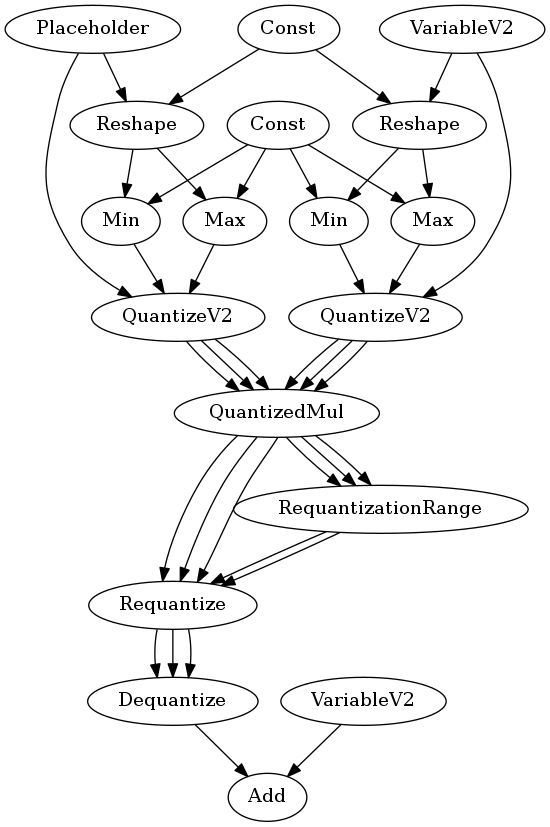

In [135]:
from IPython.display import Image

Image('/root/notebooks/quantize_nodes_optimized_cpu.png')

### Benchmarks

In [52]:
%%bash

benchmark_model --graph=/root/models/optimize_me/linear/cpu/quantize_nodes_optimized_cpu.pb \
                --input_layer=x_observed,bias,weights \
                --input_layer_type=float,float,float \
                --input_layer_shape=:: \
                --output_layer=add

2017-05-24 14:44:33.363060: I tensorflow/tools/benchmark/benchmark_model.cc:381] Graph: [/root/models/optimize_me/linear/cpu/quantize_nodes_optimized_cpu.pb]
2017-05-24 14:44:33.363146: I tensorflow/tools/benchmark/benchmark_model.cc:382] Input layers: [x_observed,bias,weights]
2017-05-24 14:44:33.363162: I tensorflow/tools/benchmark/benchmark_model.cc:383] Input shapes: [::]
2017-05-24 14:44:33.363172: I tensorflow/tools/benchmark/benchmark_model.cc:384] Input types: [float,float,float]
2017-05-24 14:44:33.363181: I tensorflow/tools/benchmark/benchmark_model.cc:385] Output layers: [add]
2017-05-24 14:44:33.363195: I tensorflow/tools/benchmark/benchmark_model.cc:386] Num runs: [50]
2017-05-24 14:44:33.363205: I tensorflow/tools/benchmark/benchmark_model.cc:387] Inter-run delay (seconds): [-1.0]
2017-05-24 14:44:33.363214: I tensorflow/tools/benchmark/benchmark_model.cc:388] Num threads: [-1]
2017-05-24 14:44:33.363223: I tensorflow/tools/benchmark/benchmark_model.cc:389] Benchmark name

## Sort by Execution Order
* aka. Topological Order Sort
* Minimize inference overhead 
* Inputs for a each node are guaranteed to be available on the forward path

In [136]:
%%bash

transform_graph \
--in_graph=/root/models/optimize_me/linear/cpu/unoptimized_model_cpu.pb \
--out_graph=/root/models/optimize_me/linear/cpu/sort_by_execution_order_optimized_cpu.pb \
--inputs='x_observed' \
--outputs='add' \
--transforms='
strip_unused_nodes
remove_nodes(op=Identity, op=CheckNumerics)
fold_constants(ignore_errors=true)
fold_batch_norms
fold_old_batch_norms
quantize_weights
quantize_nodes
sort_by_execution_order'

2017-05-24 15:38:49.937432: I tensorflow/tools/graph_transforms/transform_graph.cc:257] Applying strip_unused_nodes
2017-05-24 15:38:49.937788: I tensorflow/tools/graph_transforms/transform_graph.cc:257] Applying remove_nodes
2017-05-24 15:38:49.938259: I tensorflow/tools/graph_transforms/transform_graph.cc:257] Applying fold_constants
2017-05-24 15:38:49.952492: I tensorflow/tools/graph_transforms/transform_graph.cc:257] Applying fold_batch_norms
2017-05-24 15:38:49.952707: I tensorflow/tools/graph_transforms/transform_graph.cc:257] Applying fold_old_batch_norms
2017-05-24 15:38:49.952866: I tensorflow/tools/graph_transforms/transform_graph.cc:257] Applying quantize_weights
2017-05-24 15:38:49.952960: I tensorflow/tools/graph_transforms/transform_graph.cc:257] Applying quantize_nodes
2017-05-24 15:38:49.955280: I tensorflow/tools/graph_transforms/transform_graph.cc:257] Applying sort_by_execution_order


### File Size

In [137]:
%%bash

ls -l /root/models/optimize_me/linear/cpu/

total 84
-rw-r--r-- 1 root root   149 May 24 14:26 checkpoint
-rw-r--r-- 1 root root   424 May 24 15:33 fold_batch_norms_optimized_cpu.pb
-rw-r--r-- 1 root root   424 May 24 15:28 fold_constants_optimized_cpu.pb
-rw-r--r-- 1 root root   424 May 24 14:44 fully_optimized_cpu.pb
-rw-r--r-- 1 root root     8 May 24 14:26 model.ckpt.data-00000-of-00001
-rw-r--r-- 1 root root   143 May 24 14:26 model.ckpt.index
-rw-r--r-- 1 root root 21374 May 24 14:26 model.ckpt.meta
-rw-r--r-- 1 root root  2230 May 24 15:37 quantize_nodes_optimized_cpu.pb
-rw-r--r-- 1 root root   424 May 24 15:35 quantize_weights_optimized_cpu.pb
-rw-r--r-- 1 root root   271 May 24 15:25 remove_nodes_optimized_cpu.pb
-rw-r--r-- 1 root root  2230 May 24 15:38 sort_by_execution_order_optimized_cpu.pb
-rw-r--r-- 1 root root   271 May 24 15:24 strip_unused_optimized_cpu.pb
-rw-r--r-- 1 root root 14947 May 24 14:26 unoptimized_model_cpu.pb


### Graph

In [138]:
%%bash

summarize_graph --in_graph=/root/models/optimize_me/linear/cpu/sort_by_execution_order_optimized_cpu.pb

Found 1 possible inputs: (name=x_observed, type=float(1), shape=[]) 
Found 2 variables: (name=bias, type=float(1), shape=[]) (name=weights, type=float(1), shape=[]) 
Found 1 possible outputs: (name=add, op=Add) 
Found 2 (2) const parameters, 0 (0) variable parameters, and 0 control_edges
4 nodes assigned to device '/device:CPU:0'Op types used: 2 Const, 2 Max, 2 Min, 2 QuantizeV2, 2 Reshape, 2 VariableV2, 1 Add, 1 Dequantize, 1 Placeholder, 1 QuantizedMul, 1 RequantizationRange, 1 Requantize
To use with tensorflow/tools/benchmark:benchmark_model try these arguments:
bazel run tensorflow/tools/benchmark:benchmark_model -- --graph=/root/models/optimize_me/linear/cpu/sort_by_execution_order_optimized_cpu.pb --show_flops --logtostderr --input_layer=x_observed,bias,weights --input_layer_type=float,float,float --input_layer_shape=:: --output_layer=add


2017-05-24 15:38:52.014381: W tensorflow/tools/graph_transforms/summarize_graph_main.cc:183] Decoding Tensor failed for nodebias
2017-05-24 15:38:52.014452: W tensorflow/tools/graph_transforms/summarize_graph_main.cc:183] Decoding Tensor failed for nodeweights


In [139]:
input_graph='/root/models/optimize_me/linear/cpu/sort_by_execution_order_optimized_cpu.pb'
output_dot='/root/notebooks/sort_by_execution_order_optimized_cpu.dot'
convert_graph_to_dot(input_graph=input_graph, output_dot=output_dot, is_input_graph_binary=True)

Created dot file '/root/notebooks/sort_by_execution_order_optimized_cpu.dot' for graph '/root/models/optimize_me/linear/cpu/sort_by_execution_order_optimized_cpu.pb'.


In [140]:
%%bash

dot -T png /root/notebooks/sort_by_execution_order_optimized_cpu.dot \
    -o /root/notebooks/sort_by_execution_order_optimized_cpu.png > /tmp/a.out

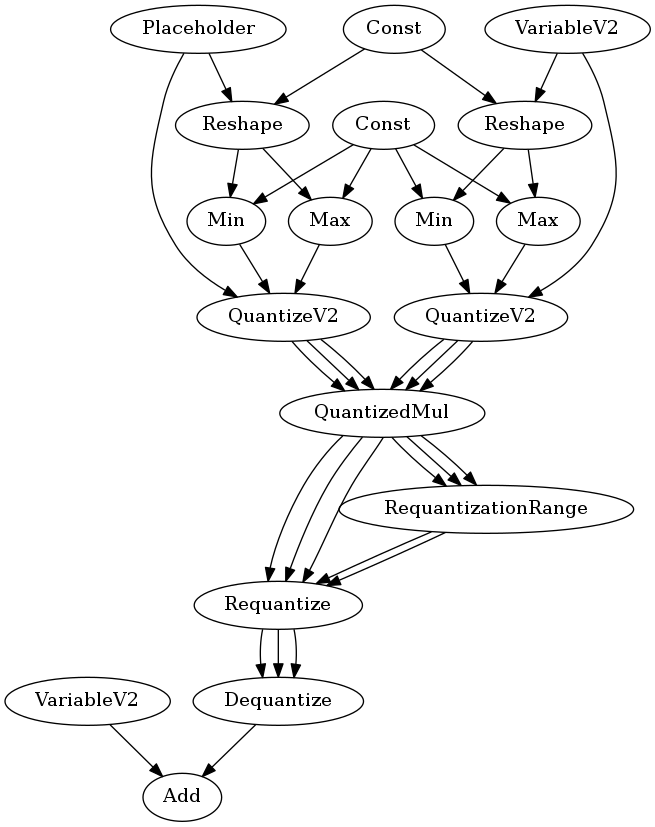

In [141]:
from IPython.display import Image

Image('/root/notebooks/sort_by_execution_order_optimized_cpu.png')

### Benchmarks

In [142]:
%%bash

benchmark_model --graph=/root/models/optimize_me/linear/cpu/sort_by_execution_order_optimized_cpu.pb \
    --input_layer=x_observed,bias,weights \
    --input_layer_type=float,float,float \
    --input_layer_shape=:: \
    --output_layer=add

2017-05-24 15:39:07.332201: I tensorflow/tools/benchmark/benchmark_model.cc:381] Graph: [/root/models/optimize_me/linear/cpu/sort_by_execution_order_optimized_cpu.pb]
2017-05-24 15:39:07.332279: I tensorflow/tools/benchmark/benchmark_model.cc:382] Input layers: [x_observed,bias,weights]
2017-05-24 15:39:07.332295: I tensorflow/tools/benchmark/benchmark_model.cc:383] Input shapes: [::]
2017-05-24 15:39:07.332306: I tensorflow/tools/benchmark/benchmark_model.cc:384] Input types: [float,float,float]
2017-05-24 15:39:07.332315: I tensorflow/tools/benchmark/benchmark_model.cc:385] Output layers: [add]
2017-05-24 15:39:07.332330: I tensorflow/tools/benchmark/benchmark_model.cc:386] Num runs: [50]
2017-05-24 15:39:07.332340: I tensorflow/tools/benchmark/benchmark_model.cc:387] Inter-run delay (seconds): [-1.0]
2017-05-24 15:39:07.332350: I tensorflow/tools/benchmark/benchmark_model.cc:388] Num threads: [-1]
2017-05-24 15:39:07.332359: I tensorflow/tools/benchmark/benchmark_model.cc:389] Bench

## Combine All Optimizations

In [143]:
%%bash

transform_graph \
--in_graph=/root/models/optimize_me/linear/cpu/unoptimized_model_cpu.pb \
--out_graph=/root/models/optimize_me/linear/cpu/fully_optimized_cpu.pb \
--inputs='x_observed' \
--outputs='add' \
--transforms='
add_default_attributes
remove_nodes(op=Identity, op=CheckNumerics)
fold_constants(ignore_errors=true)
fold_batch_norms
fold_old_batch_norms
quantize_weights
strip_unused_nodes
sort_by_execution_order'
#quantize_nodes

2017-05-24 15:39:07.765394: I tensorflow/tools/graph_transforms/transform_graph.cc:257] Applying add_default_attributes
2017-05-24 15:39:07.783165: I tensorflow/tools/graph_transforms/transform_graph.cc:257] Applying remove_nodes
2017-05-24 15:39:07.793776: I tensorflow/tools/graph_transforms/transform_graph.cc:257] Applying fold_constants
2017-05-24 15:39:07.795204: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.1 instructions, but these are available on your machine and could speed up CPU computations.
2017-05-24 15:39:07.795248: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.2 instructions, but these are available on your machine and could speed up CPU computations.
2017-05-24 15:39:07.795263: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX instructions, but these are available on your machine and could speed up CPU com

### File Size

In [144]:
%%bash

ls -l /root/models/optimize_me/linear/cpu/

total 84
-rw-r--r-- 1 root root   149 May 24 14:26 checkpoint
-rw-r--r-- 1 root root   424 May 24 15:33 fold_batch_norms_optimized_cpu.pb
-rw-r--r-- 1 root root   424 May 24 15:28 fold_constants_optimized_cpu.pb
-rw-r--r-- 1 root root   424 May 24 15:39 fully_optimized_cpu.pb
-rw-r--r-- 1 root root     8 May 24 14:26 model.ckpt.data-00000-of-00001
-rw-r--r-- 1 root root   143 May 24 14:26 model.ckpt.index
-rw-r--r-- 1 root root 21374 May 24 14:26 model.ckpt.meta
-rw-r--r-- 1 root root  2230 May 24 15:37 quantize_nodes_optimized_cpu.pb
-rw-r--r-- 1 root root   424 May 24 15:35 quantize_weights_optimized_cpu.pb
-rw-r--r-- 1 root root   271 May 24 15:25 remove_nodes_optimized_cpu.pb
-rw-r--r-- 1 root root  2230 May 24 15:38 sort_by_execution_order_optimized_cpu.pb
-rw-r--r-- 1 root root   271 May 24 15:24 strip_unused_optimized_cpu.pb
-rw-r--r-- 1 root root 14947 May 24 14:26 unoptimized_model_cpu.pb


### Graph

In [145]:
%%bash

summarize_graph --in_graph=/root/models/optimize_me/linear/cpu/fully_optimized_cpu.pb

Found 1 possible inputs: (name=x_observed, type=float(1), shape=[]) 
Found 2 variables: (name=weights, type=float(1), shape=[]) (name=bias, type=float(1), shape=[]) 
Found 1 possible outputs: (name=add, op=Add) 
Found 0 (0) const parameters, 0 (0) variable parameters, and 0 control_edges
5 nodes assigned to device '/device:CPU:0'Op types used: 2 VariableV2, 1 Add, 1 Mul, 1 Placeholder
To use with tensorflow/tools/benchmark:benchmark_model try these arguments:
bazel run tensorflow/tools/benchmark:benchmark_model -- --graph=/root/models/optimize_me/linear/cpu/fully_optimized_cpu.pb --show_flops --logtostderr --input_layer=x_observed,weights,bias --input_layer_type=float,float,float --input_layer_shape=:: --output_layer=add


2017-05-24 15:39:09.381852: W tensorflow/tools/graph_transforms/summarize_graph_main.cc:183] Decoding Tensor failed for nodeweights
2017-05-24 15:39:09.381929: W tensorflow/tools/graph_transforms/summarize_graph_main.cc:183] Decoding Tensor failed for nodebias


In [146]:
input_graph='/root/models/optimize_me/linear/cpu/fully_optimized_cpu.pb'
output_dot='/root/notebooks/fully_optimized_cpu.dot'
convert_graph_to_dot(input_graph=input_graph, output_dot=output_dot, is_input_graph_binary=True)

Created dot file '/root/notebooks/fully_optimized_cpu.dot' for graph '/root/models/optimize_me/linear/cpu/fully_optimized_cpu.pb'.


In [147]:
%%bash

dot -T png /root/notebooks/fully_optimized_cpu.dot \
    -o /root/notebooks/fully_optimized_cpu.png > /tmp/a.out

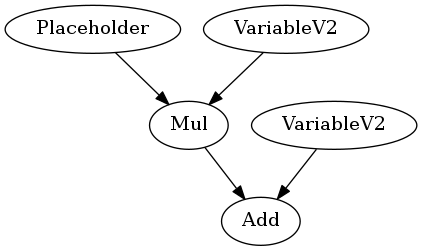

In [148]:
from IPython.display import Image

Image('/root/notebooks/fully_optimized_cpu.png')

### Benchmarks

In [ ]:
%%bash

benchmark_model --graph=/root/models/optimize_me/linear/cpu/fully_optimized_cpu.pb \
    --input_layer=weights,x_observed,bias \
    --input_layer_type=float,float,float \
    --input_layer_shape=:: \
    --output_layer=add

## Obfuscate Names
Shorten and mangle internal graph node names

In [ ]:
%%bash

transform_graph \
--in_graph=/root/models/optimize_me/linear/cpu/fully_optimized_cpu.pb \
--out_graph=/root/models/optimize_me/linear/cpu/obfuscate_names_optimized_cpu.pb \
--inputs='x_observed' \
--outputs='add' \
--transforms='
obfuscate_names'

### File Size

In [ ]:
%%bash

ls -l /root/models/optimize_me/linear/cpu/

### Graph

In [ ]:
%%bash

summarize_graph --in_graph=/root/models/optimize_me/linear/cpu/obfuscate_names_optimized_cpu.pb

## Freeze Fully Optimized Graph

In [ ]:
from tensorflow.python.tools import freeze_graph

optimize_me_parent_path = '/root/models/optimize_me/linear/cpu'

fully_optimized_model_graph_path = '%s/fully_optimized_cpu.pb' % optimize_me_parent_path
fully_optimized_frozen_model_graph_path = '%s/fully_optimized_frozen_cpu.pb' % optimize_me_parent_path

model_checkpoint_path = '%s/model.ckpt' % optimize_me_parent_path

freeze_graph.freeze_graph(input_graph=fully_optimized_model_graph_path, 
                          input_saver="",
                          input_binary=True, 
                          input_checkpoint='/root/models/optimize_me/linear/cpu/model.ckpt', 
                          output_node_names="add",
                          restore_op_name="save/restore_all", 
                          filename_tensor_name="save/Const:0",
                          output_graph=fully_optimized_frozen_model_graph_path, 
                          clear_devices=True, 
                          initializer_nodes="")
print(fully_optimized_frozen_model_graph_path)

## Reset Default Graph

In [ ]:
graph = tf.reset_default_graph()

## Create New Session

In [ ]:
import tensorflow as tf

sess = tf.Session()

In [ ]:
from datetime import datetime 

version = int(datetime.now().strftime("%s"))

In [ ]:
fully_optimized_saved_model_path = '/root/models/linear_fully_optimized/cpu/%s' % version

print(fully_optimized_saved_model_path)

In [ ]:
import tensorflow as tf
from tensorflow.python.saved_model import builder as saved_model_builder
from tensorflow.python.saved_model import signature_constants
from tensorflow.python.saved_model import signature_def_utils
from tensorflow.python.saved_model import tag_constants
from tensorflow.python.saved_model import utils

print(fully_optimized_frozen_model_graph_path)

# Load GraphDef created above
with tf.gfile.GFile(fully_optimized_frozen_model_graph_path, 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())

# Import GraphDef from above into current graph
tf.import_graph_def(
    graph_def, 
    input_map=None, 
    return_elements=None, 
    name="", 
    op_dict=None, 
    producer_op_list=None
)

In [ ]:
graph = tf.get_default_graph()

for op in graph.get_operations():
    print(op.name)

x_observed = graph.get_tensor_by_name('x_observed:0')
print(x_observed)

y_pred = graph.get_tensor_by_name('add:0')
print(y_pred)

tensor_info_x_observed = utils.build_tensor_info(x_observed)
print(tensor_info_x_observed)

tensor_info_y_pred = utils.build_tensor_info(y_pred)
print(tensor_info_y_pred)

builder = saved_model_builder.SavedModelBuilder(fully_optimized_saved_model_path)

prediction_signature = signature_def_utils.build_signature_def(inputs = 
                {'x_observed': tensor_info_x_observed}, 
                outputs = {'y_pred': tensor_info_y_pred}, 
                method_name = signature_constants.PREDICT_METHOD_NAME)

builder.add_meta_graph_and_variables(sess, [tag_constants.SERVING],
                             signature_def_map={'predict':prediction_signature,                                     
                                                signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY:prediction_signature}, 
                              clear_devices=True,
)

builder.save(as_text=False)

In [ ]:
import os

os.listdir(fully_optimized_saved_model_path)

In [ ]:
sess.close()